## ARC 380 / CEE 380 – Introduction to Robotics for Digital Fabrication
## Session 18 Workshop
Princeton University, Spring 2024

Professor: Arash Adel | Assistant-in-Instruction: Daniel Ruan

---

*If you are on mac and had an issue last time importing open3d in a notebook, the solution is to put it in its own cell like below. Let us know if this does not work still.

In [1]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

Open3D documentation: https://www.open3d.org/docs/release/index.html

# 1. Point Cloud Filtering

Text(0.5, 1.0, 'Workshop example scene')

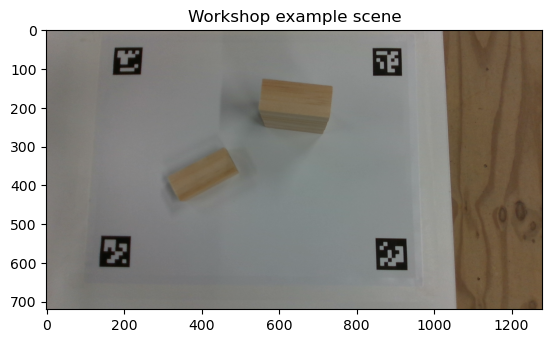

In [2]:
# Import and view workshop image
img = cv2.imread('example_img.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Workshop example scene')

In [3]:
# Import workshop point cloud
pcd = o3d.io.read_point_cloud("example_pcd.ply")

print(f'Loaded point cloud has {len(pcd.points)} points.')

Loaded point cloud has 325101 points.


In [4]:
# Visualize point cloud
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
coordinate_frame.rotate(np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]]), center=[0, 0, 0])    # Rotate to match camera frame
o3d.visualization.draw_geometries([pcd, coordinate_frame])

## 1.1. Downsampling

We might not need to downsample our point cloud since is not unreasonably large and we might want to preserve all of the points to maximize precision for our small-scale example.

In many real-time applications, however, computation speed might be a higher priority, which makes downsampling essential.

In [5]:
# Downsample the point cloud using voxel grid
voxel_size = 0.001   # Meters
down_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
print(f'Downsampled point cloud has {len(down_pcd.points)} points.')

Downsampled point cloud has 231940 points.


In [6]:
# Visualize downsampled point cloud
o3d.visualization.draw_geometries([down_pcd, coordinate_frame])

## 1.2. Background removal

In our specific setup, we know roughly how the camera is set up, and where the table is (approx. 30 cm from the camera). We can use this information to discard points beyond this distance (with some tolerance) to remove the background.

In [7]:
# Remove points beyond a certain z distance from the camera
max_distance = 0.5   # Meters

np_down_pcd = np.asarray(down_pcd.points)
within_dist_idx = np.where(np.abs(np_down_pcd[:, 2]) < max_distance)[0]
filtered_pcd = down_pcd.select_by_index(within_dist_idx)

print(f'Filtered point cloud has {len(filtered_pcd.points)} points.')

Filtered point cloud has 101980 points.


In [8]:
# Visualize filtered point cloud
o3d.visualization.draw_geometries([filtered_pcd, coordinate_frame])

## 1.3. Outlier removal

From viewing the point cloud, we don't have many outliers since the camera is pretty close to our scene and the environment conditions (lighting, surface textures, etc.) are not difficult for the camera. Even so, it is good practice to perform an outlier removal.

In [9]:
# Remove outlier points using statistical outlier removal
nb_neighbors = 20
std_ratio = 2
filtered_pcd, idx = filtered_pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)

print(f'Outlier removed point cloud has {len(filtered_pcd.points)} points.')


Outlier removed point cloud has 99188 points.


In [10]:
o3d.visualization.draw_geometries([filtered_pcd, coordinate_frame])

---
# 2. Point cloud segmentation

At this point, our point cloud has been reasonably filtered (we don't need to reconstruct the mesh surface), and we can begin segmentation.

We can use RANSAC to segment the table plane, and clustering to identify each brick stack.

We will cover point cloud segmentation and 3D feature extraction techniques in more detail next week.


In [10]:
# Use RANSAC to fit a plane and locate the table surface
plane_model, inliers = filtered_pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
[a, b, c, d] = plane_model
print(f'Plane model: {a}x + {b}y + {c}z + {d} = 0')

Plane model: -0.004938893277066706x + 0.11406548771480494y + 0.9934609563770392z + 0.3009804677684685 = 0


In [15]:
# Visualize the inliers of the plane
inlier_pcd = filtered_pcd.select_by_index(inliers)
inlier_pcd.paint_uniform_color([1, 0, 0])
print(f'Plane inliers point cloud has {len(inlier_pcd.points)} points.')

outlier_pcd = filtered_pcd.select_by_index(inliers, invert=True)
print(f'Plane outliers point cloud has {len(outlier_pcd.points)} points.')

o3d.visualization.draw_geometries([inlier_pcd, outlier_pcd, coordinate_frame])

Plane inliers point cloud has 97624 points.
Plane outliers point cloud has 1564 points.


In [19]:
# Basic segmentation of the outlier point cloud using DBSCAN clustering
labels = outlier_pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True)
labels = np.asarray(labels)
print(f'Found {len(np.unique(labels))} clusters.')

Found 2 clusters.


More about DBSCAN clustering:

Ester, Martin, et al. "A density-based algorithm for discovering clusters in large spatial databases with noise." *kdd*. Vol. 96. No. 34. 1996.

In [31]:
# Visualize the clusters in different colors
cluster_1 = outlier_pcd.select_by_index(np.where(labels == 0)[0])
cluster_1.paint_uniform_color([0, 1, 0])

cluster_2 = outlier_pcd.select_by_index(np.where(labels == 1)[0])
cluster_2.paint_uniform_color([0, 0, 1])

o3d.visualization.draw_geometries([cluster_1, cluster_2, coordinate_frame])